# **IMPORTS**

In [ ]:
from google.colab import userdata
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [ ]:
from PIL import Image
import json
import os
import torch
from transformers import pipeline
import cv2
import numpy as np

In [ ]:
print("CUDA available:", torch.cuda.is_available())


CUDA available: True


In [ ]:
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
login()

In [ ]:
!huggingface-cli whoami

sebicu14


In [ ]:
!pip install bitsandbytes

In [ ]:
from transformers import BitsAndBytesConfig

In [ ]:
!pip install mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.2/373.2 kB 12.1 MB/s eta 0:00:00


# IMAGE PREPROCESSING

In [ ]:
import matplotlib.pyplot as plt
import cv2

def display_transformed_image(title,image):
    # Convert BGR (OpenCV) to RGB (matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display with matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(title)
    plt.show()


https://pyimagesearch.com/2021/10/27/automatically-ocring-receipts-and-scans/


In [ ]:
import cv2
import imutils
from imutils.perspective import four_point_transform
import numpy as np

def process_receipt_image(image_path):
    orig = cv2.imread(image_path)
    if orig is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    image = imutils.resize(orig, width=500)
    ratio = orig.shape[1] / float(image.shape[1])

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)

    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    receiptCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
          area = cv2.contourArea(approx)
          if area > 1000:  # adjust threshold based on your image resolution
              receiptCnt = approx
              break

    if receiptCnt is not None:
        # Found the receipt contour, apply perspective transform on original image
        receipt = four_point_transform(orig, receiptCnt.reshape(4, 2) * ratio)
        return receipt
    else:
        #best version
        gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        gray = cv2.medianBlur(gray, 3)
        gray = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        preprocessed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)



        # preprocessed = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        # preprocessed = cv2.fastNlMeansDenoising(preprocessed, None, h=30, templateWindowSize=7, searchWindowSize=21)
        # preprocessed = cv2.equalizeHist(preprocessed)
        # preprocessed = cv2.GaussianBlur(preprocessed, (5, 5), 0)
        # sharpen_kernel = np.array([[0, -1, 0],
        #                        [-1, 5, -1],
        #                        [0, -1, 0]])
        # preprocessed = cv2.filter2D(preprocessed, -1, sharpen_kernel)
        # preprocessed = cv2.adaptiveThreshold(preprocessed, 255,
        #                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        #                                  cv2.THRESH_BINARY, 11, 2)
        # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        # preprocessed = cv2.morphologyEx(preprocessed, cv2.MORPH_CLOSE, kernel)




        # preprocessed = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        # preprocessed = cv2.GaussianBlur(preprocessed, (5, 5), 0)
        # _, preprocessed = cv2.threshold(preprocessed, 110, 255, cv2.THRESH_BINARY)
        # preprocessed = cv2.Canny(preprocessed, 75, 200)



        # gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        # blurred = cv2.GaussianBlur(gray, (1, 1), 0)
        # edged = 255 - cv2.Canny(blurred, 100, 150, apertureSize=7)
        # thresh, preprocessed = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)
        return preprocessed

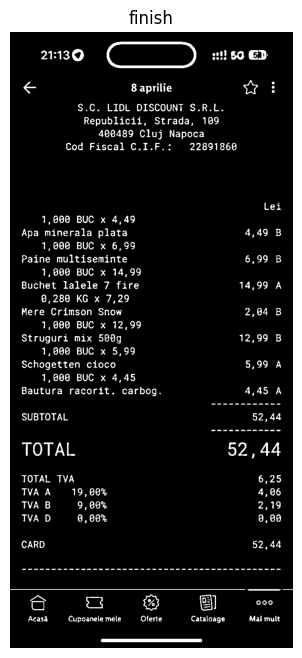

<class 'numpy.ndarray'>


In [ ]:
result_img = process_receipt_image('receipt1.jpg')
display_transformed_image("finish",result_img)
print(type(result_img))

In [ ]:
import base64
import cv2
import numpy as np
from mistralai import Mistral

def encode_image_from_ndarray(image):
    """Encode a NumPy ndarray image to a base64 JPEG string."""
    try:
        success, encoded_image = cv2.imencode('.jpg', image)
        if not success:
            raise ValueError("Image encoding failed.")
        return base64.b64encode(encoded_image.tobytes()).decode('utf-8')
    except Exception as e:
        print(f"Error encoding image: {e}")
        return None

def process_image_with_mistral(image_ndarray, api_key):
    """Process an image (ndarray) with Mistral OCR."""
    base64_image = encode_image_from_ndarray(image_ndarray)
    if base64_image is None:
        print("Failed to encode image.")
        return None

    client = Mistral(api_key=api_key)

    response = client.ocr.process(
        model="mistral-ocr-latest",
        document={
            "type": "image_url",
            "image_url": f"data:image/jpeg;base64,{base64_image}"
        }
    )

    return response


In [ ]:
api_key = "1u8ji4SwxWRHakL32DbNom8kBJm2LkCH"

ocr_result = process_image_with_mistral(result_img, api_key)
print(ocr_result.pages[0].markdown)

21:130
::!! 50 ED
8 aprilie
S.C. LIDL DISCOUNT S.R.L.
Republicii, Strada, 109
400489 Cluj Napoca
Cod Fiscal C.I.F.: 22891860

Lei
1,000 BUC x 4,49
Apa minerala plata
4,49 B
1,000 BUC x 6,99
Paine multiseminte
6,99 B
1,000 BUC x 14,99
Buchet lalele 7 fire
14,99 A
0,280 KG x 7,29
Mere Crimson Snow
2,04 B
1,000 BUC x 12,99
Struguri mix 500g
12,99 B
1,000 BUC x 5,99
Schogetten cioco
5,99 A
1,000 BUC x 4,45
Bautura racorit. carbog.
4,45 A
SUBTOTAL
52,44
TOTAL
52,44
TOTAL TVA
6,25
TVA A 19,00%
4,06
TVA B 9,00%
2,19
TVA D 0,00%
0,00
CARD
52,44

Acasa
☐
☐
Cupoanele mele
Oferte
Cataloage
000
Mal mult


# MISTRAL AI

# **LAMMA CONFIGURATION**

In [ ]:
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype="float16"
# )

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,  # Nested quantization for further memory savings
    bnb_4bit_quant_type="nf4"  # Normal Float 4 format for better accuracy-size trade-off
)

In [ ]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline
import torch

# llama_pipeline = pipeline("text-generation",
#                           model="meta-llama/Llama-3.2-3B-Instruct",
#                           torch_dtype=torch.bfloat16,
#                           quantization_config=quantization_config,
#                           device_map="auto")


llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

Device set to use cuda:0


In [ ]:
def build_receipt_prompt(receipt_data):
    prompt = f"""
You are given text from an OCR scan of a supermarket receipt. Your task is to extract and return a structured JSON object with the following fields:

---

**Top-level fields:**
- **store**: Extract the store name (usually near the top, e.g., "S.C. LIDL DISCOUNT S.R.L."). If not found, use an empty string.
- **total**: Extract the amount following the word "TOTAL" (replace commas with dots).
- **payment_method**: Either "CARD" or "CASH", found after the total. If neither exists, use an empty string.

---

**Items array:**
Extract each product as a JSON object with:
- **quantity** (float): From the line like "1,000 BUC × 4,49". Convert comma to dot.
- **unit_price** (float): From the same line after the × symbol. Convert comma to dot.
- **name** (string): From the *next* line, exclude the trailing price and any single letters (e.g., "B").
- **total_price** (float): From the same line as the name, last number. Convert comma to dot.

---

**Item Extraction Rules:**
- Every item appears in **two consecutive lines**:
  - First line: quantity + unit price (e.g., `1,000 BUC × 4,49`)
  - Second line: product name + total price (e.g., `Apa minerala plata 4,49 B`)
- Remove all trailing characters (like "A", "B", etc.) from product names.
- Only add the item to the result if **both lines are valid and contain extractable numbers**.
- **Do not guess** or default to 0. If values are missing or unrecognizable, **skip that item**.

---

Example:

Input lines:
0,280 KG × 7,29
Mere Crimson Snow 2,04 B

Output JSON item:
{{
  "quantity": 0.280,
  "unit_price": 7.29,
  "name": "Mere Crimson Snow",
  "total_price": 2.04
}}

1,000 BUC × 12,99
Struguri mix 500g 12,99 B

Output JSON item:
{{
  "quantity": 1.0,
  "unit_price": 12.99,
  "name": "Struguri mix 500g",
  "total_price": 12.99
}}

Now, extract the structured JSON for the receipt below:

{receipt_data}

Your output should be only the JSON object and nothing else.
"""
    return prompt


In [ ]:
def generate_extraction(prompt):
    messages = [
      {"role": "system", "content": "You are a good chatbot that understand the format of receipt and always return just a json response"},
      {"role": "user", "content": prompt},
  ]
    outputs = llama_pipeline(
      messages,
      max_new_tokens=700,
  )
    return outputs[0]["generated_text"][-1]



In [ ]:
import re
import json

def process_receipt(image_path):

    api_key = "1u8ji4SwxWRHakL32DbNom8kBJm2LkCH"
    result_img = process_receipt_image(image_path)


    ocr_result = process_image_with_mistral(result_img, api_key)

    # Build prompt from OCR result (you should have this already)
    prompt = build_receipt_prompt(ocr_result.pages[0].markdown)
    print("Prompt")
    print(prompt)

    print("LLM response")
    llm_output = generate_extraction(prompt)
    print(llm_output)

    if llm_output is None:
        print("❌ Error: No output from LLM.")
        return

    # Extract the 'content' part if it's a dict
    if isinstance(llm_output, dict) and 'content' in llm_output:
        content = llm_output['content']
    else:
        content = llm_output  # assume raw text

    # content = content.strip()
    content = re.sub(r"^```(?:json)?\s*|\s*```$", "", content.strip(), flags=re.MULTILINE)


    # if content.startswith("```"):
    #     content = content.split("```")[1].strip()

    try:
        data = json.loads(content)
        return data
    except json.JSONDecodeError as e:
        print(f"❌ JSON parsing failed: {e}")
        print("LLM Output:\n", content)
        return

    # ✅ Now print the structured output
    print(f"Store: {data.get('store', 'Unknown')}\n")
    print("Items:\n")
    for item in data.get('items', []):
        print(f"- {item['name']}")
        print(f"  Quantity: {item['quantity']}")
        print(f"  Unit Price: {item['unit_price']} Lei")
        print(f"  Total Price: {item['total_price']} Lei\n")
    print(f"Total: {data.get('total', 'Unknown')} Lei\n")
    print(f"Payment Method: {data.get('payment_method', 'Unknown')}\n")


In [ ]:
process_receipt('receipt1.jpg')

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Prompt

You are given text from an OCR scan of a supermarket receipt. Your task is to extract and return a structured JSON object with the following fields:

---

**Top-level fields:**
- **store**: Extract the store name (usually near the top, e.g., "S.C. LIDL DISCOUNT S.R.L."). If not found, use an empty string.
- **total**: Extract the amount following the word "TOTAL" (replace commas with dots).
- **payment_method**: Either "CARD" or "CASH", found after the total. If neither exists, use an empty string.

---

**Items array:**
Extract each product as a JSON object with:
- **quantity** (float): From the line like "1,000 BUC × 4,49". Convert comma to dot.
- **unit_price** (float): From the same line after the × symbol. Convert comma to dot.
- **name** (string): From the *next* line, exclude the trailing price and any single letters (e.g., "B").
- **total_price** (float): From the same line as the name, last number. Convert comma to dot.

---

**Item Extraction Rules:**
- Every item app

{'store': 'S.C. LIDL DISCOUNT S.R.L.',
 'total': '52.44',
 'payment_method': 'CARD',
 'items': [{'quantity': 1.0,
   'unit_price': 4.49,
   'name': 'Apa minerala plata',
   'total_price': 4.49},
  {'quantity': 1.0,
   'unit_price': 6.99,
   'name': 'Paine multiseminte',
   'total_price': 6.99},
  {'quantity': 1.0,
   'unit_price': 14.99,
   'name': 'Buchet lalele 7 fire',
   'total_price': 14.99},
  {'quantity': 0.28,
   'unit_price': 7.29,
   'name': 'Mere Crimson Snow',
   'total_price': 2.04},
  {'quantity': 1.0,
   'unit_price': 12.99,
   'name': 'Struguri mix 500g',
   'total_price': 12.99},
  {'quantity': 1.0,
   'unit_price': 5.99,
   'name': 'Schogetten cioco',
   'total_price': 5.99},
  {'quantity': 1.0,
   'unit_price': 4.45,
   'name': 'Bautura racorit. carbog.',
   'total_price': 4.45}]}

# REST API ENDPOINT

In [ ]:
!pip install fastapi uvicorn nest-asyncio pyngrok

In [ ]:
!pip install python-multipart


In [ ]:
!ngrok authtoken 2xipNMgtG9W0bO2qnLBMNSxphfp_7VNVuXiNLc6P4YZv75gLG

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import nest_asyncio
import uvicorn
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from pyngrok import ngrok
import json


ngrok.set_auth_token("2xipNMgtG9W0bO2qnLBMNSxphfp_7VNVuXiNLc6P4YZv75gLG")


app = FastAPI()

from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel


app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # React app origin
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# @app.get("/ping")
# async def ping():
#     return JSONResponse(content={"msg": "pong"})

from fastapi import Request



class Message(BaseModel):
    text: str

@app.post("/text")
async def receive_text(message: Message):
    print(f"Received text: {message.text}")
    return {"received": message.text}

@app.post("/upload")
async def upload_file(file: UploadFile = File(...)):
    print("It worked!")
    contents = await file.read()
    print(f"Received file of size: {len(contents)} bytes")

    # TODO: Replace this with your real receipt processing logic
    # receipt_data = {
    #     "store": "Test Store",
    #     "total": 123.45,
    #     "payment_method": "Card",
    #     "items": [
    #         {"quantity": 1, "unit_price": 10, "name": "Item A", "total_price": 10},
    #         {"quantity": 2, "unit_price": 5, "name": "Item B", "total_price": 10},
    #     ]
    # }

    # return receipt_data

    # Save the uploaded file

    # return {"filename": file.filename, "size": len(contents)}

    file_location = f"/content/{file.filename}"
    with open(file_location, "wb") as f:
        f.write(contents)

    # Process the receipt image
    receipt_data = process_receipt(file_location)

    # Return JSON with 'content' as stringified JSON
    if receipt_data is None:
        return JSONResponse(status_code=400, content={"error": "Failed to process receipt"})

    # Return JSON with structured receipt data
    return JSONResponse(content=receipt_data)





def start_ngrok():
    public_url = ngrok.connect(8000, "http", request_header={
        "add": ["ngrok-skip-browser-warning:true"]
    })
    print(f"Public URL: {public_url}")
    return public_url

nest_asyncio.apply()

public_url = start_ngrok()
uvicorn.run(app, host="127.0.0.1", port=8000)


Public URL: NgrokTunnel: "https://70aa-34-125-117-41.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [1217]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     109.166.139.154:0 - "OPTIONS /upload HTTP/1.1" 200 OK
It worked!
Received file of size: 389393 bytes


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Prompt

You are given text from an OCR scan of a supermarket receipt. Your task is to extract and return a structured JSON object with the following fields:

---

**Top-level fields:**
- **store**: Extract the store name (usually near the top, e.g., "S.C. LIDL DISCOUNT S.R.L."). If not found, use an empty string.
- **total**: Extract the amount following the word "TOTAL" (replace commas with dots).
- **payment_method**: Either "CARD" or "CASH", found after the total. If neither exists, use an empty string.

---

**Items array:**
Extract each product as a JSON object with:
- **quantity** (float): From the line like "1,000 BUC × 4,49". Convert comma to dot.
- **unit_price** (float): From the same line after the × symbol. Convert comma to dot.
- **name** (string): From the *next* line, exclude the trailing price and any single letters (e.g., "B").
- **total_price** (float): From the same line as the name, last number. Convert comma to dot.

---

**Item Extraction Rules:**
- Every item app

# SECTION **2**